In [1]:
pip install pystac-client planetary-computer rasterio tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [planetary-computer]
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pystac_client import Client
import planetary_computer as pc

STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = Client.open(STAC_URL)

uk_bbox = (-8.8, 49.7, 2.2, 61.2)

search = catalog.search(
    collections=["cop-dem-glo-90"],   
    bbox=uk_bbox
)

items = list(search.get_items())
print("tiles:", len(items))
print("first item id:", items[0].id)
print("assets keys:", list(items[0].assets.keys()))


/opt/anaconda3/lib/python3.13/site-packages/pystac_client/item_search.py:925: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


tiles: 98
first item id: Copernicus_DSM_COG_30_N61_00_W008_00_DEM
assets keys: ['data', 'tilejson', 'rendered_preview']


In [3]:
item = items[0]

asset = item.assets.get("data")  
href_signed = pc.sign(asset.href)

print("signed href:", href_signed[:120], "...")


signed href: https://elevationeuwest.blob.core.windows.net/copernicus-dem/COP90_hh/Copernicus_DSM_COG_30_N61_00_W008_00_DEM.tif?st=20 ...


In [4]:
import rasterio

with rasterio.open(href_signed) as src:
    print(src.crs, src.transform, src.width, src.height)
    arr = src.read(1, window=((0, 512), (0, 512)))  
    print(arr.min(), arr.max())


EPSG:4326 | 0.00, 0.00,-8.00|
| 0.00,-0.00, 62.00|
| 0.00, 0.00, 1.00| 600 1200
0.0 0.0


In [5]:
import rasterio
from rasterio.merge import merge
from tqdm import tqdm

signed_hrefs = []
for it in items:
    a = it.assets.get("data") or next(iter(it.assets.values()))
    signed_hrefs.append(pc.sign(a.href))

srcs = [rasterio.open(h) for h in tqdm(signed_hrefs, desc="open tiles")]

mosaic, out_transform = merge(srcs)

out_meta = srcs[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform,
    "compress": "deflate"
})

out_tif = "uk_dem_mosaic.tif"
with rasterio.open(out_tif, "w", **out_meta) as dst:
    dst.write(mosaic)

for s in srcs:
    s.close()

print("saved:", out_tif)


open tiles: 100%|███████████████████████████████| 98/98 [00:07<00:00, 12.96it/s]


saved: uk_dem_mosaic.tif


In [6]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping


ne_url = "https://raw.githubusercontent.com/nvkelso/natural-earth-vector/master/geojson/ne_110m_admin_0_countries.geojson"

countries = gpd.read_file(ne_url)
uk = countries[countries["NAME"] == "United Kingdom"].to_crs("EPSG:4326")

with rasterio.open("uk_dem_mosaic.tif") as src:
    # 确保边界 CRS 与栅格一致
    uk2 = uk.to_crs(src.crs)

    out_img, out_transform = mask(
        src,
        [mapping(uk2.geometry.iloc[0])],
        crop=True,
        nodata=src.nodata if src.nodata is not None else -9999
    )

    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_img.shape[1],
        "width": out_img.shape[2],
        "transform": out_transform,
        "nodata": -9999
    })

with rasterio.open("uk_dem_clipped_UK.tif", "w", **out_meta) as dst:
    dst.write(out_img)

print("saved: uk_dem_clipped_UK.tif")


saved: uk_dem_clipped_UK.tif


In [7]:

with rasterio.open("uk_dem_mosaic.tif") as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)   # 看 left/right/bottom/top


CRS: EPSG:4326
Bounds: BoundingBox(left=-9.000625, bottom=49.000416666666666, right=2.9993750000000006, top=62.000416666666666)


In [8]:

with rasterio.open("uk_dem_clipped_UK.tif") as src:
    print("bounds:", src.bounds)


bounds: BoundingBox(left=-7.572291666666666, bottom=49.95958333333333, right=1.682708333333335, top=58.635416666666664)


In [10]:
import os
from rasterio.mask import mask
from shapely.geometry import mapping

BASE = "/Users/jsh/Desktop/assignment2 spatial"

boundary_path = os.path.join(BASE, "uk boundary.geojson")
dem_path      = os.path.join(BASE, "uk_dem_mosaic.tif")
out_path      = os.path.join(BASE, "uk_dem_clipped_UK.tif")


gdf = gpd.read_file(boundary_path)
uk_poly = gdf.dissolve()

with rasterio.open(dem_path) as src:
    uk_poly2 = uk_poly.to_crs(src.crs)  # CRS 对齐
    geom = mapping(uk_poly2.geometry.iloc[0])

    out_img, out_transform = mask(
        src,
        [geom],
        crop=True,
        nodata=-9999
    )

    meta = src.meta.copy()
    meta.update(
        height=out_img.shape[1],
        width=out_img.shape[2],
        transform=out_transform,
        nodata=-9999,
        compress="deflate"
    )

with rasterio.open(out_path, "w", **meta) as dst:
    dst.write(out_img)

print("✅ saved:", out_path)


ni_count = (gdf["LAD25CD"].astype(str).str.startswith("N")).sum() if "LAD25CD" in gdf.columns else None
print("NI LAD count:", ni_count)


✅ saved: /Users/jsh/Desktop/assignment2 spatial/uk_dem_clipped_UK.tif
NI LAD count: 11


In [13]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import shapes
from shapely.geometry import shape, mapping


BASE = "/Users/jsh/Desktop/assignment2 spatial"

BOUNDARY = os.path.join(BASE, "uk boundary.geojson")
DEM_MOSAIC = os.path.join(BASE, "uk_dem_mosaic.tif")

DEM_CLIPPED = os.path.join(BASE, "uk_dem_clipped_UK.tif")
DEM_3035    = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")

SLOPE_TIF = os.path.join(BASE, "uk_slope_deg_epsg3035.tif")
MASK_TIF  = os.path.join(BASE, "uk_slope_gt15_epsg3035.tif")

OUT_GPKG  = os.path.join(BASE, "uk_slope_gt15.gpkg")
OUT_GEOJS = os.path.join(BASE, "uk_slope_gt15.geojson")

THRESH_DEG = 15.0
NODATA_OUT = -9999



def clip_dem_to_uk(dem_in, boundary_geojson, dem_out):
    gdf = gpd.read_file(boundary_geojson)

    # dissolve all LAD polygons into a single UK outline
    uk_poly = gdf.dissolve()

    with rasterio.open(dem_in) as src:
        uk_poly2 = uk_poly.to_crs(src.crs)
        geom = mapping(uk_poly2.geometry.iloc[0])

        out_img, out_transform = mask(
            src, [geom],
            crop=True,
            nodata=NODATA_OUT
        )

        meta = src.meta.copy()
        meta.update({
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform,
            "nodata": NODATA_OUT,
            "compress": "deflate"
        })

    with rasterio.open(dem_out, "w", **meta) as dst:
        dst.write(out_img)

    print("✅ clipped DEM:", dem_out)


def reproject_to_3035(src_tif, dst_tif):
    dst_crs = "EPSG:3035"
    with rasterio.open(src_tif) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        meta = src.meta.copy()
        meta.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height,
            "compress": "deflate"
        })

        with rasterio.open(dst_tif, "w", **meta) as dst:
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.bilinear
            )

    print("✅ reprojected:", dst_tif)



def horn_slope_degrees(dem, xres, yres, nodata):
    dem = dem.astype("float32")
    if nodata is not None:
        dem = np.where(dem == nodata, np.nan, dem)

    # 3x3 neighborhood (Horn)
    z1 = dem[:-2, :-2]; z2 = dem[:-2, 1:-1]; z3 = dem[:-2, 2:]
    z4 = dem[1:-1, :-2]; z5 = dem[1:-1, 1:-1]; z6 = dem[1:-1, 2:]
    z7 = dem[2:, :-2];  z8 = dem[2:, 1:-1]; z9 = dem[2:, 2:]

    dzdx = ((z3 + 2*z6 + z9) - (z1 + 2*z4 + z7)) / (8.0 * xres)
    dzdy = ((z7 + 2*z8 + z9) - (z1 + 2*z2 + z3)) / (8.0 * yres)

    slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
    slope_deg = np.degrees(slope_rad).astype("float32")

    out = np.full_like(dem, np.nan, dtype="float32")
    out[1:-1, 1:-1] = slope_deg
    return out


def compute_slope_and_mask(dem_3035_path, slope_out, mask_out, threshold_deg):
    with rasterio.open(dem_3035_path) as src:
        dem = src.read(1)
        xres = src.transform.a
        yres = abs(src.transform.e)
        nodata = src.nodata

        slope = horn_slope_degrees(dem, xres, yres, nodata)


        meta_slope = src.meta.copy()
        meta_slope.update({"dtype": "float32", "count": 1, "nodata": np.nan, "compress": "deflate"})
        with rasterio.open(slope_out, "w", **meta_slope) as dst:
            dst.write(slope, 1)


        mask_arr = np.where(slope > threshold_deg, 1, 0).astype("uint8")
        meta_mask = src.meta.copy()
        meta_mask.update({"dtype": "uint8", "count": 1, "nodata": 0, "compress": "deflate"})
        with rasterio.open(mask_out, "w", **meta_mask) as dst:
            dst.write(mask_arr, 1)

    print("✅ slope:", slope_out)
    print("✅ mask :", mask_out)


def polygonize_mask(mask_path, out_gpkg_path, out_geojson_path=None, min_area_m2=0):
    with rasterio.open(mask_path) as src:
        img = src.read(1)
        m = img == 1

        geoms = []
        for geom, val in shapes(img, mask=m, transform=src.transform):
            if int(val) == 1:
                geoms.append(shape(geom))

        if len(geoms) == 0:
            raise ValueError("⚠️ No polygons found for slope>threshold. Check mask/threshold/nodata.")


        gdf = gpd.GeoDataFrame(
            {"slope_gt15": [1] * len(geoms)},
            geometry=geoms,
            crs=src.crs
        )


    gdf = gdf.dissolve(by="slope_gt15").reset_index()

    if min_area_m2 and min_area_m2 > 0:
        gdf["area_m2"] = gdf.geometry.area
        gdf = gdf[gdf["area_m2"] >= min_area_m2].copy()

    gdf.to_file(out_gpkg_path, layer="slope_gt15", driver="GPKG")
    print("✅ polygons (gpkg):", out_gpkg_path)

    if out_geojson_path:
        gdf.to_file(out_geojson_path, driver="GeoJSON")
        print("✅ polygons (geojson):", out_geojson_path)


if __name__ == "__main__":

    if not os.path.exists(DEM_CLIPPED):
        clip_dem_to_uk(DEM_MOSAIC, BOUNDARY, DEM_CLIPPED)
    else:
        print("ℹ️ using existing:", DEM_CLIPPED)


    if not os.path.exists(DEM_3035):
        reproject_to_3035(DEM_CLIPPED, DEM_3035)
    else:
        print("ℹ️ using existing:", DEM_3035)


    compute_slope_and_mask(DEM_3035, SLOPE_TIF, MASK_TIF, THRESH_DEG)

 
    polygonize_mask(MASK_TIF, OUT_GPKG, OUT_GEOJS, min_area_m2=0)

    print("\n🎉 Done. Final outputs:")
    print(" -", SLOPE_TIF)
    print(" -", MASK_TIF)
    print(" -", OUT_GPKG)
    print(" -", OUT_GEOJS)


ℹ️ using existing: /Users/jsh/Desktop/assignment2 spatial/uk_dem_clipped_UK.tif
✅ reprojected: /Users/jsh/Desktop/assignment2 spatial/uk_dem_clipped_UK_epsg3035.tif
✅ slope: /Users/jsh/Desktop/assignment2 spatial/uk_slope_deg_epsg3035.tif
✅ mask : /Users/jsh/Desktop/assignment2 spatial/uk_slope_gt15_epsg3035.tif
✅ polygons (gpkg): /Users/jsh/Desktop/assignment2 spatial/uk_slope_gt15.gpkg
✅ polygons (geojson): /Users/jsh/Desktop/assignment2 spatial/uk_slope_gt15.geojson

🎉 Done. Final outputs:
 - /Users/jsh/Desktop/assignment2 spatial/uk_slope_deg_epsg3035.tif
 - /Users/jsh/Desktop/assignment2 spatial/uk_slope_gt15_epsg3035.tif
 - /Users/jsh/Desktop/assignment2 spatial/uk_slope_gt15.gpkg
 - /Users/jsh/Desktop/assignment2 spatial/uk_slope_gt15.geojson


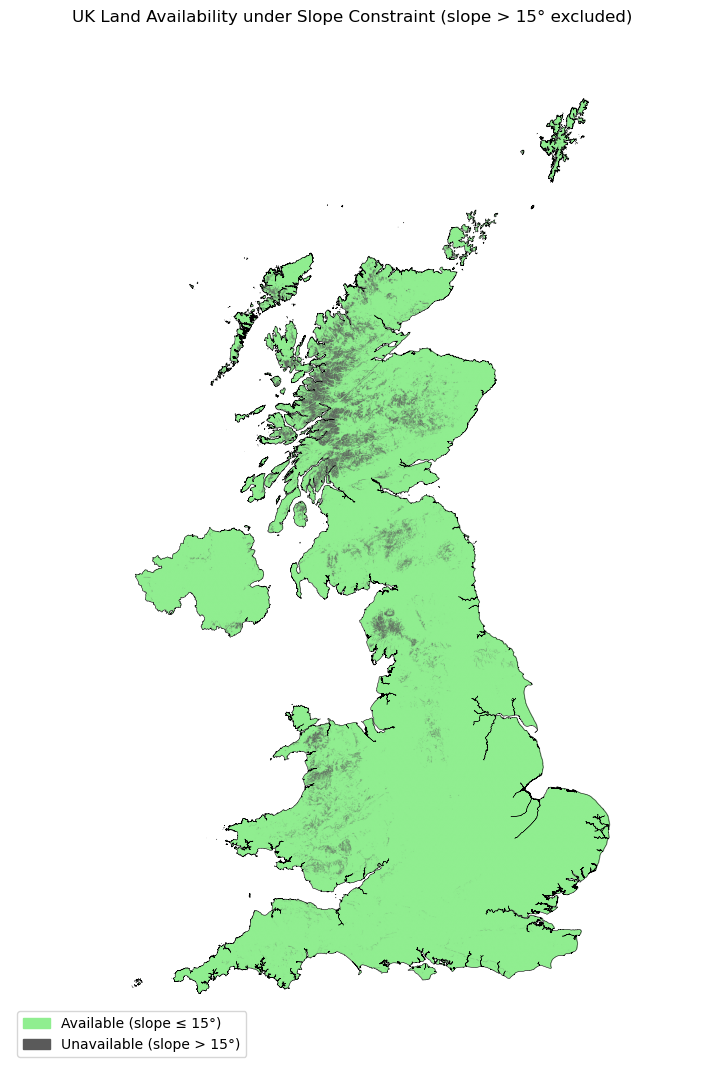

✅ saved: /Users/jsh/Desktop/assignment2 spatial/uk_available_vs_unavailable_slope15.png


In [43]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

BASE = "/Users/jsh/Desktop/assignment2 spatial"

mask_tif = os.path.join(BASE, "uk_slope_gt15_epsg3035.tif")    
dem_tif  = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif") 
boundary = os.path.join(BASE, "uk boundary.geojson")        

out_png = os.path.join(BASE, "uk_available_vs_unavailable_slope15.png")


with rasterio.open(mask_tif) as msrc:
    m = msrc.read(1)
    transform = msrc.transform
    crs = msrc.crs
    extent = (
        msrc.bounds.left, msrc.bounds.right,
        msrc.bounds.bottom, msrc.bounds.top
    )

with rasterio.open(dem_tif) as dsrc:
    dem = dsrc.read(1).astype("float32")
    dem_nodata = dsrc.nodata
    if dem_nodata is not None:
        valid = dem != dem_nodata
    else:
        valid = ~np.isnan(dem)


class_map = np.full_like(m, fill_value=np.nan, dtype="float32")
class_map[valid & (m == 0)] = 0  # available
class_map[valid & (m == 1)] = 1  # unavailable

gdf = gpd.read_file(boundary)
uk_outline = gdf.dissolve().to_crs(crs)


fig, ax = plt.subplots(figsize=(9, 11))


cmap = ListedColormap(["#90EE90", "#5A5A5A"])  

im = ax.imshow(
    class_map,
    extent=extent,
    origin="upper",
    cmap=cmap,
    vmin=0, vmax=1
)


uk_outline.boundary.plot(ax=ax, linewidth=0.3, color="black")


import matplotlib.patches as mpatches
legend_handles = [
    mpatches.Patch(color="#90EE90", label="Available (slope ≤ 15°)"),
    mpatches.Patch(color="#5A5A5A", label="Unavailable (slope > 15°)")
]
ax.legend(handles=legend_handles, loc="lower left", frameon=True)

ax.set_title("UK Land Availability under Slope Constraint (slope > 15° excluded)")
ax.set_axis_off()

plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()

print("✅ saved:", out_png)



✅ saved mask: /Users/jsh/Desktop/assignment2 spatial/uk_elev_gtH_epsg3035.tif


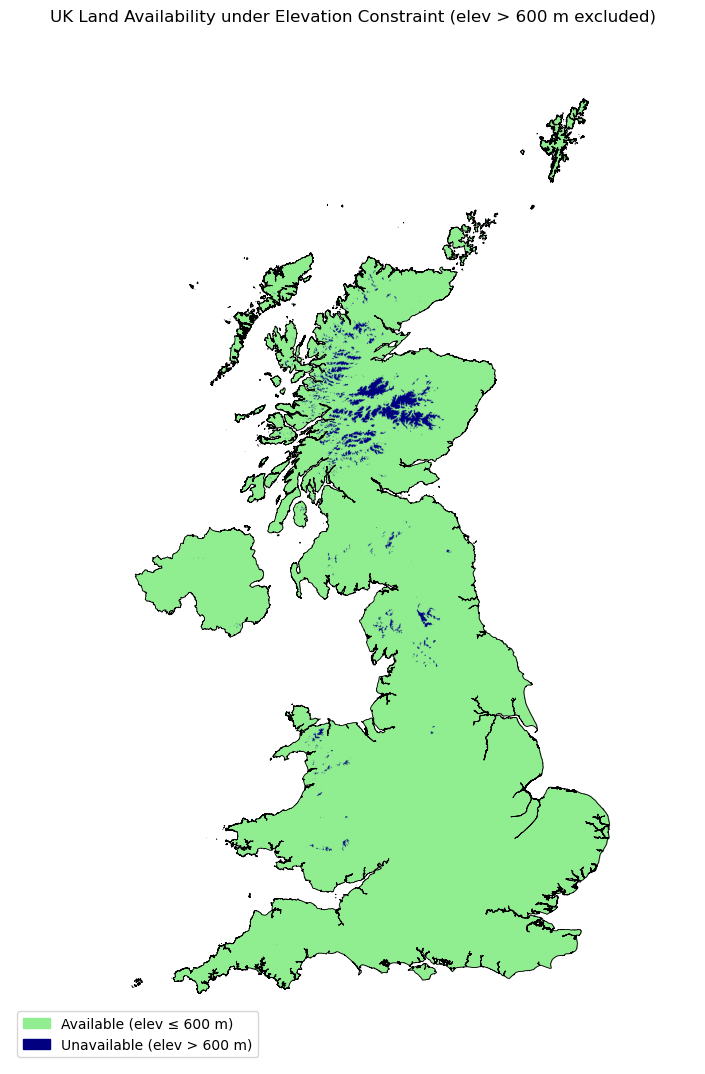

✅ saved figure: /Users/jsh/Desktop/assignment2 spatial/uk_available_vs_unavailable_elevH.png


In [46]:
from matplotlib.colors import ListedColormap


BASE = "/Users/jsh/Desktop/assignment2 spatial"

dem_tif   = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")  
boundary  = os.path.join(BASE, "uk boundary.geojson")


mask_tif  = os.path.join(BASE, "uk_elev_gtH_epsg3035.tif")
out_png   = os.path.join(BASE, "uk_available_vs_unavailable_elevH.png")

H = 600.0 


with rasterio.open(dem_tif) as src:
    dem = src.read(1).astype("float32")
    nodata = src.nodata
    crs = src.crs
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

    valid = (dem != nodata) if nodata is not None else ~np.isnan(dem)

  
    elev_mask = np.zeros_like(dem, dtype="uint8")
    elev_mask[valid & (dem > H)] = 1
    elev_mask[~valid] = 0

    meta = src.meta.copy()
    meta.update(dtype="uint8", nodata=0, compress="deflate")

    with rasterio.open(mask_tif, "w", **meta) as dst:
        dst.write(elev_mask, 1)

print("✅ saved mask:", mask_tif)

gdf = gpd.read_file(boundary)
uk_outline = gdf.dissolve().to_crs(crs)

class_map = np.full_like(elev_mask, np.nan, dtype="float32")
class_map[valid & (elev_mask == 0)] = 0  # available
class_map[valid & (elev_mask == 1)] = 1  # unavailable

cmap = ListedColormap(["#90EE90", "#000080"])  

fig, ax = plt.subplots(figsize=(9, 11))
ax.imshow(class_map, extent=extent, origin="upper", cmap=cmap, vmin=0, vmax=1)

uk_outline.boundary.plot(ax=ax, linewidth=0.6, color="black")

legend_handles = [
    mpatches.Patch(color="#90EE90", label=f"Available (elev ≤ {int(H)} m)"),
    mpatches.Patch(color="#000080", label=f"Unavailable (elev > {int(H)} m)")
]
ax.legend(handles=legend_handles, loc="lower left", frameon=True)

ax.set_title(f"UK Land Availability under Elevation Constraint (elev > {int(H)} m excluded)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()

print("✅ saved figure:", out_png)


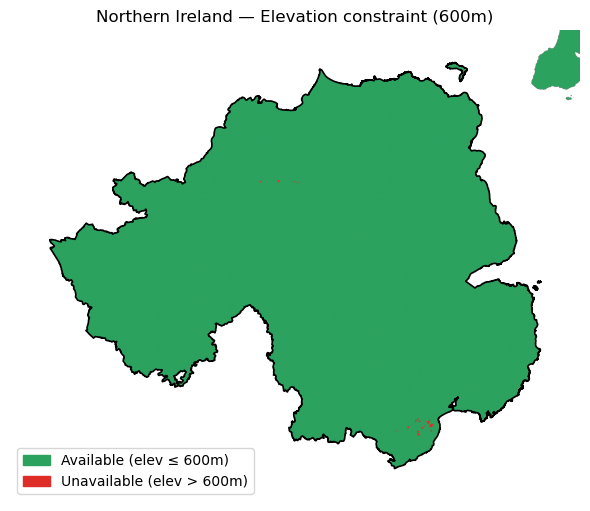

saved: /Users/jsh/Desktop/assignment2 spatial/NI_zoom_elev600.png


In [21]:
import matplotlib.patches as mpatches


BASE = "/Users/jsh/Desktop/assignment2 spatial"

class_tif = os.path.join(BASE, "uk_elev_gtH_epsg3035.tif")          
dem_tif   = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")  
boundary  = os.path.join(BASE, "uk boundary.geojson")
out_png   = os.path.join(BASE, "NI_zoom_elev600.png")

with rasterio.open(class_tif) as src:
    m = src.read(1).astype("uint8")
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
    crs = src.crs

with rasterio.open(dem_tif) as dsrc:
    dem = dsrc.read(1).astype("float32")
    nodata = dsrc.nodata
    valid = (dem != nodata) if nodata is not None else ~np.isnan(dem)

class_map = np.full_like(m, np.nan, dtype="float32")
class_map[valid & (m == 0)] = 0
class_map[valid & (m == 1)] = 1

gdf = gpd.read_file(boundary).to_crs(crs)
ni = gdf[gdf["LAD25CD"].astype(str).str.startswith("N")].dissolve()


minx, miny, maxx, maxy = ni.total_bounds

cmap = ListedColormap(["#2ca25f", "#de2d26"])

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(class_map, extent=extent, origin="upper", cmap=cmap, vmin=0, vmax=1)


ni.boundary.plot(ax=ax, linewidth=1.2, color="black")


padx = (maxx - minx) * 0.08
pady = (maxy - miny) * 0.08
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

legend_handles = [
    mpatches.Patch(color="#2ca25f", label="Available (elev ≤ 600m)"),
    mpatches.Patch(color="#de2d26", label="Unavailable (elev > 600m)")
]
ax.legend(handles=legend_handles, loc="lower left", frameon=True)
ax.set_title("Northern Ireland — Elevation constraint (600m)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()

print("saved:", out_png)


✅ saved final mask: /Users/jsh/Desktop/assignment2 spatial/uk_hard_constraints_final_mask.tif
Available area:  228,699 km² (93.6%)
Unavailable area:15,730 km² (6.4%)


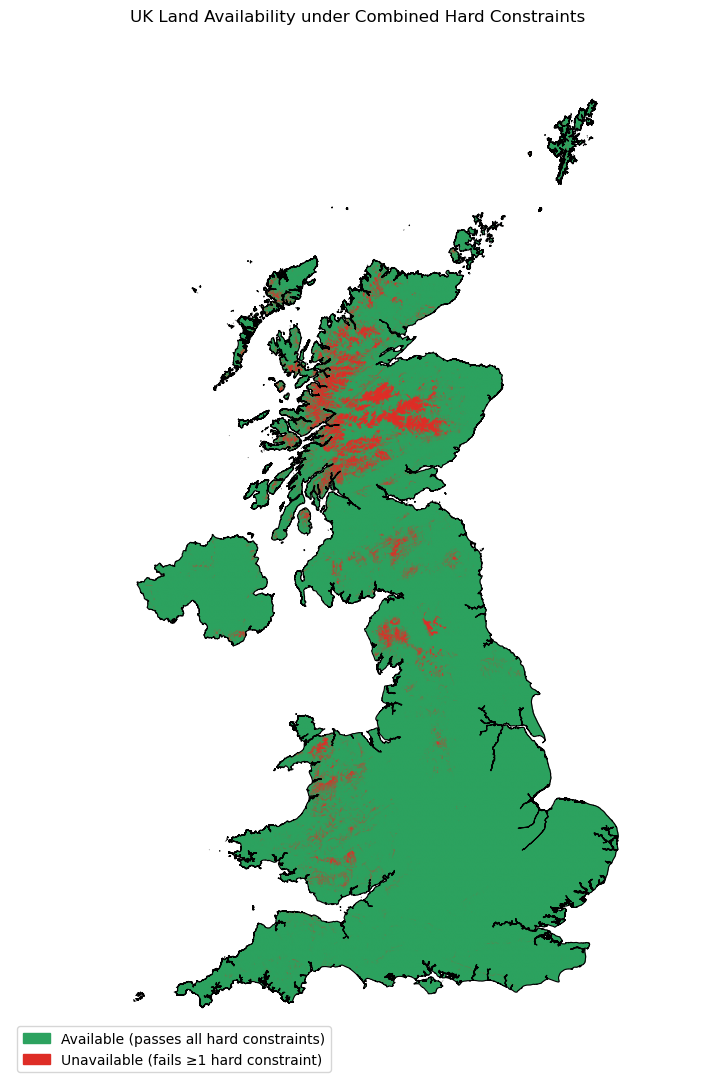

✅ saved figure: /Users/jsh/Desktop/assignment2 spatial/uk_available_vs_unavailable_FINAL.png


In [17]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"

slope_mask_tif = os.path.join(BASE, "uk_slope_gt15_epsg3035.tif")   # 1=unavailable, 0=available
elev_mask_tif  = os.path.join(BASE, "uk_elev_gtH_epsg3035.tif")     # 1=unavailable, 0=available
dem_tif        = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")# for valid area
boundary       = os.path.join(BASE, "uk boundary.geojson")

final_mask_tif = os.path.join(BASE, "uk_hard_constraints_final_mask.tif")
out_png        = os.path.join(BASE, "uk_available_vs_unavailable_FINAL.png")


with rasterio.open(dem_tif) as dsrc:
    dem = dsrc.read(1).astype("float32")
    dem_nodata = dsrc.nodata
    valid = (dem != dem_nodata) if dem_nodata is not None else ~np.isnan(dem)
    crs = dsrc.crs
    transform = dsrc.transform
    extent = (dsrc.bounds.left, dsrc.bounds.right, dsrc.bounds.bottom, dsrc.bounds.top)


with rasterio.open(slope_mask_tif) as ssrc:
    slope_m = ssrc.read(1).astype("uint8")

with rasterio.open(elev_mask_tif) as esrc:
    elev_m = esrc.read(1).astype("uint8")


final_m = np.zeros_like(slope_m, dtype="uint8")
final_m[valid & ((slope_m == 1) | (elev_m == 1))] = 1
final_m[~valid] = 0


with rasterio.open(dem_tif) as src_ref:
    meta = src_ref.meta.copy()
meta.update(dtype="uint8", nodata=0, compress="deflate")

with rasterio.open(final_mask_tif, "w", **meta) as dst:
    dst.write(final_m, 1)

print("✅ saved final mask:", final_mask_tif)


px_area_m2 = abs(transform.a * transform.e)
available_area_km2 = (np.sum(valid & (final_m == 0)) * px_area_m2) / 1e6
unavail_area_km2    = (np.sum(valid & (final_m == 1)) * px_area_m2) / 1e6
total_area_km2      = (np.sum(valid) * px_area_m2) / 1e6
print(f"Available area:  {available_area_km2:,.0f} km² ({available_area_km2/total_area_km2*100:.1f}%)")
print(f"Unavailable area:{unavail_area_km2:,.0f} km² ({unavail_area_km2/total_area_km2*100:.1f}%)")

uk_outline = gpd.read_file(boundary).dissolve().to_crs(crs)


class_map = np.full_like(final_m, np.nan, dtype="float32")
class_map[valid & (final_m == 0)] = 0
class_map[valid & (final_m == 1)] = 1

cmap = ListedColormap(["#2ca25f", "#de2d26"]) 
fig, ax = plt.subplots(figsize=(9, 11))
ax.imshow(class_map, extent=extent, origin="upper", cmap=cmap, vmin=0, vmax=1)
uk_outline.boundary.plot(ax=ax, linewidth=0.8, color="black")

legend_handles = [
    mpatches.Patch(color="#2ca25f", label="Available (passes all hard constraints)"),
    mpatches.Patch(color="#de2d26", label="Unavailable (fails ≥1 hard constraint)")
]
ax.legend(handles=legend_handles, loc="lower left", frameon=True)

ax.set_title("UK Land Availability under Combined Hard Constraints")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()

print("✅ saved figure:", out_png)


In [19]:
BASE = "/Users/jsh/Desktop/assignment2 spatial"
slope_mask_tif = os.path.join(BASE, "uk_slope_gt15_epsg3035.tif")
elev_mask_tif  = os.path.join(BASE, "uk_elev_gtH_epsg3035.tif")
dem_tif        = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")

def info(path):
    with rasterio.open(path) as src:
        a = src.read(1)
        print("\n==", os.path.basename(path), "==")
        print("crs:", src.crs)
        print("shape:", a.shape)
        print("transform:", src.transform)
        print("bounds:", src.bounds)
        print("unique:", np.unique(a, return_counts=True)[:2])  # 只看前2项避免太长

info(dem_tif)
info(slope_mask_tif)
info(elev_mask_tif)



== uk_dem_clipped_UK_epsg3035.tif ==
crs: EPSG:3035
shape: (13940, 9235)
transform: | 94.93, 0.00, 2996498.66|
| 0.00,-94.93, 4329015.39|
| 0.00, 0.00, 1.00|
bounds: BoundingBox(left=2996498.6642836574, bottom=3005682.2043264927, right=3873183.169153756, top=4329015.393052987)
unique: (array([-9999.      ,   -58.715717,   -54.93353 , ...,  1322.1156  ,
        1324.0723  ,  1327.89    ], dtype=float32), array([101612737,         1,         1, ...,         1,         1,
               1]))

== uk_slope_gt15_epsg3035.tif ==
crs: EPSG:3035
shape: (13940, 9235)
transform: | 94.93, 0.00, 2996498.66|
| 0.00,-94.93, 4329015.39|
| 0.00, 0.00, 1.00|
bounds: BoundingBox(left=2996498.6642836574, bottom=3005682.2043264927, right=3873183.169153756, top=4329015.393052987)
unique: (array([0, 1], dtype=uint8), array([127356589,   1379311]))

== uk_elev_gtH_epsg3035.tif ==
crs: EPSG:3035
shape: (13940, 9235)
transform: | 94.93, 0.00, 2996498.66|
| 0.00,-94.93, 4329015.39|
| 0.00, 0.00, 1.00|
bounds: B

In [20]:
from rasterio.mask import mask
from shapely.geometry import mapping

BASE = "/Users/jsh/Desktop/assignment2 spatial"
boundary = os.path.join(BASE, "uk boundary.geojson")
dem_tif  = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")

gdf = gpd.read_file(boundary)

ni = gdf[gdf["LAD25CD"].astype(str).str.startswith("N")].dissolve()

with rasterio.open(dem_tif) as src:
    ni2 = ni.to_crs(src.crs)
    out, _ = mask(src, [mapping(ni2.geometry.iloc[0])], crop=True, nodata=src.nodata)
    a = out[0].astype("float32")
    nodata = src.nodata
    valid = (a != nodata) if nodata is not None else ~np.isnan(a)

    print("NI max elev (m):", np.nanmax(np.where(valid, a, np.nan)))
    print("NI pixels > 600m:", int(np.sum(valid & (a > 600))))
    print("NI pixels > 400m:", int(np.sum(valid & (a > 400))))


NI max elev (m): 833.5256
NI pixels > 600m: 744
NI pixels > 400m: 18609


In [27]:

import warnings
from rasterio import features
import pyogrio  

warnings.filterwarnings("ignore", "GeoSeries.notna", UserWarning)


BASE = "/Users/jsh/Desktop/assignment2 spatial"

dem_tif = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")  # EPSG:3035 alignment grid
uk_boundary = os.path.join(BASE, "uk boundary.geojson")

】
gb_rivers_gpkg = os.path.join(BASE, "oprvrs_gb.gpkg")
gb_rivers_layer = "watercourse_link"
gb_lakes_gpkg  = os.path.join(BASE, "uklakes_v3_6_poly.gpkg")
gb_lakes_layer = "uklakes_v3_6_poly"


ni_river_shp = os.path.join(BASE, "WFD_River_Water_Bodies_2016.shp")
ni_lake_shp  = os.path.join(BASE, "Lake_Water_Bodies_2016.shp")

】
WATER_BUFFER_M = 200


out_mask_tif = os.path.join(BASE, f"uk_water_constraints_{WATER_BUFFER_M}m_mask.tif")
out_png      = os.path.join(BASE, f"uk_water_constraints_{WATER_BUFFER_M}m_blue.png")



def safe_make_valid(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Drop missing/empty geometries and fix invalid ones."""
    gdf = gdf[gdf.geometry.notna()].copy()
    # drop empty geometries
    gdf = gdf[~gdf.geometry.is_empty].copy()

    # fix invalid geometries
    try:
        gdf["geometry"] = gdf.geometry.buffer(0)
    except Exception:
        pass

    gdf = gdf[gdf.geometry.notna()].copy()
    gdf = gdf[~gdf.geometry.is_empty].copy()
    return gdf


def read_vector_geom_only(path: str, layer: str | None = None) -> gpd.GeoDataFrame:
    """
    Read ONLY geometry (no attribute fields) to avoid any encoding issues.
    Works for gpkg/shp/geojson etc.
    """
    df = pyogrio.read_dataframe(
        path,
        layer=layer,
        columns=[],         
        read_geometry=True
    )
    return df


def read_vector_robust(path: str, layer: str | None = None, encoding: str | None = None) -> gpd.GeoDataFrame:
    """
    Try normal geopandas read. If UnicodeDecodeError happens, fall back to geometry-only read.
    """
    try:
        if layer is None and encoding is None:
            return gpd.read_file(path)
        if layer is None:
            return gpd.read_file(path, encoding=encoding)
        if encoding is None:
            return gpd.read_file(path, layer=layer)
        return gpd.read_file(path, layer=layer, encoding=encoding)

    except UnicodeDecodeError:
        print(f"⚠️ UnicodeDecodeError on {os.path.basename(path)} (layer={layer}). Falling back to geometry-only read.")
        return read_vector_geom_only(path, layer=layer)


def read_shp_encoding_robust(path: str) -> gpd.GeoDataFrame:
    """
    NI shapefiles DBF often not UTF-8. Try cp1252 then latin1.
    If still fails due to weird strings, fall back to geometry-only.
    """
    for enc in ["cp1252", "latin1"]:
        try:
            gdf = gpd.read_file(path, encoding=enc)
            print(f"✅ Read OK: {os.path.basename(path)} (encoding={enc})")
            return gdf
        except UnicodeDecodeError:
            continue
    print(f"⚠️ Still encoding issue in {os.path.basename(path)}. Falling back to geometry-only read.")
    return read_vector_geom_only(path)



with rasterio.open(dem_tif) as src:
    dem_crs = src.crs
    dem_transform = src.transform
    dem_shape = (src.height, src.width)
    dem_nodata = src.nodata
    dem_data = src.read(1, masked=False)

valid_area = np.ones(dem_shape, dtype=bool) if dem_nodata is None else (dem_data != dem_nodata)

print("DEM CRS:", dem_crs)
print("DEM shape:", dem_shape)



uk = read_vector_robust(uk_boundary)
uk = safe_make_valid(uk)
uk_union = uk.dissolve()
uk_union = uk_union.to_crs(dem_crs)
uk_union = safe_make_valid(uk_union)



gb_riv = read_vector_robust(gb_rivers_gpkg, layer=gb_rivers_layer)
gb_riv = safe_make_valid(gb_riv).to_crs(dem_crs)
gb_riv = gpd.clip(gb_riv, uk_union)
gb_riv = safe_make_valid(gb_riv)

gb_riv_buf = gb_riv.copy()
gb_riv_buf["geometry"] = gb_riv_buf.geometry.buffer(WATER_BUFFER_M)
gb_riv_buf = safe_make_valid(gb_riv_buf)



gb_lakes = read_vector_robust(gb_lakes_gpkg, layer=gb_lakes_layer)
gb_lakes = safe_make_valid(gb_lakes).to_crs(dem_crs)
gb_lakes = gpd.clip(gb_lakes, uk_union)
gb_lakes = safe_make_valid(gb_lakes)

gb_lakes_buf = gb_lakes.copy()
gb_lakes_buf["geometry"] = gb_lakes_buf.geometry.buffer(WATER_BUFFER_M)
gb_lakes_buf = safe_make_valid(gb_lakes_buf)



ni_riv = read_shp_encoding_robust(ni_river_shp)
ni_riv = safe_make_valid(ni_riv).to_crs(dem_crs)
ni_riv = gpd.clip(ni_riv, uk_union)
ni_riv = safe_make_valid(ni_riv)

ni_lake = read_shp_encoding_robust(ni_lake_shp)
ni_lake = safe_make_valid(ni_lake).to_crs(dem_crs)
ni_lake = gpd.clip(ni_lake, uk_union)
ni_lake = safe_make_valid(ni_lake)

ni_riv_buf = ni_riv.copy()
ni_riv_buf["geometry"] = ni_riv_buf.geometry.buffer(WATER_BUFFER_M)
ni_riv_buf = safe_make_valid(ni_riv_buf)

ni_lake_buf = ni_lake.copy()
ni_lake_buf["geometry"] = ni_lake_buf.geometry.buffer(WATER_BUFFER_M)
ni_lake_buf = safe_make_valid(ni_lake_buf)



all_excl = gpd.GeoDataFrame(
    geometry=list(gb_riv_buf.geometry) +
             list(gb_lakes_buf.geometry) +
             list(ni_riv_buf.geometry) +
             list(ni_lake_buf.geometry),
    crs=dem_crs
)
all_excl = safe_make_valid(all_excl)
all_excl = all_excl.dissolve()
all_excl = safe_make_valid(all_excl)

print("✅ Exclusion geometry ready (water <=200m).")



shapes = [(geom, 1) for geom in all_excl.geometry if geom is not None]

mask01 = features.rasterize(
    shapes=shapes,
    out_shape=dem_shape,
    transform=dem_transform,
    fill=0,
    dtype="uint8",
    all_touched=False
)

final = mask01.astype("uint8")
final[~valid_area] = 255


profile = {
    "driver": "GTiff",
    "height": dem_shape[0],
    "width": dem_shape[1],
    "count": 1,
    "dtype": "uint8",
    "crs": dem_crs,
    "transform": dem_transform,
    "compress": "LZW",
    "nodata": 255
}

with rasterio.open(out_mask_tif, "w", **profile) as dst:
    dst.write(final, 1)

print("✅ Saved mask:", out_mask_tif)


viz = final.copy()
viz[viz == 255] = 0

cmap = ListedColormap(["white", "blue"])  # 0=white, 1=blue

plt.figure(figsize=(8, 8))
plt.imshow(viz, cmap=cmap, interpolation="nearest")
plt.title(f"UK Water Constraint (<= {WATER_BUFFER_M}m = Unavailable)", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.savefig(out_png, dpi=250)
plt.close()

print("✅ Saved preview:", out_png)


DEM CRS: EPSG:3035
DEM shape: (13940, 9235)
⚠️ UnicodeDecodeError on uklakes_v3_6_poly.gpkg (layer=uklakes_v3_6_poly). Falling back to geometry-only read.


/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


✅ Read OK: WFD_River_Water_Bodies_2016.shp (encoding=cp1252)


/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


✅ Read OK: Lake_Water_Bodies_2016.shp (encoding=cp1252)


/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/anaconda3/lib/python3.13/site-packages/shapely/set_operations.py:553: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


✅ Exclusion geometry ready (water <=200m).
✅ Saved mask: /Users/jsh/Desktop/assignment2 spatial/uk_water_constraints_200m_mask.tif
✅ Saved preview: /Users/jsh/Desktop/assignment2 spatial/uk_water_constraints_200m_blue.png


DEM CRS: EPSG:3035
DEM shape: (13940, 9235)
DEM bounds: BoundingBox(left=2996498.6642836574, bottom=3005682.2043264927, right=3873183.169153756, top=4329015.393052987)
Pixel size (m): 94.93064481538696 94.93064481538696
NI river kept: 80
NI river max area km2 after filter: 26.157717804469993
NI river max width m after filter: 998.9353945358748
✅ Saved mask: /Users/jsh/Desktop/assignment2 spatial/uk_water_constraints_200m_mask.tif


Text(0.5, 1.0, 'UK Water Constraint\n(<= 200m = Unavailable)')

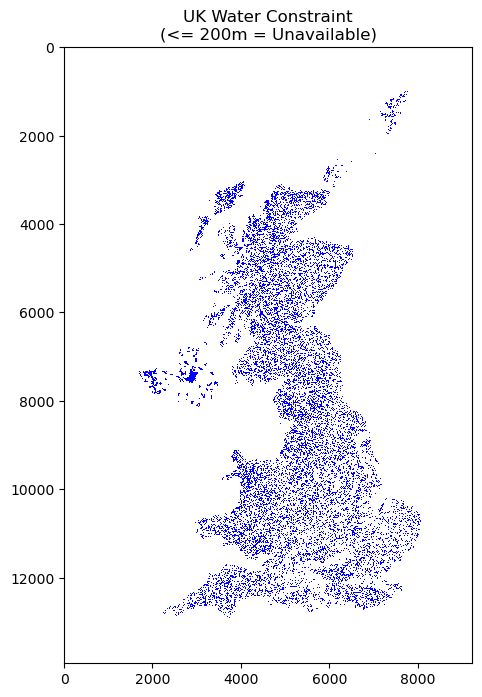

In [36]:
import os
import warnings
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import features
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore", category=RuntimeWarning)

try:
    from scipy.ndimage import distance_transform_edt
except ImportError:
    raise ImportError("缺少 scipy：请运行 conda install -c conda-forge scipy  或  pip install scipy")


BASE = "/Users/jsh/Desktop/assignment2 spatial"

dem_tif = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")
uk_boundary = os.path.join(BASE, "uk boundary.geojson")

gb_rivers_gpkg = os.path.join(BASE, "oprvrs_gb.gpkg")
gb_rivers_layer = "watercourse_link"

gb_lakes_gpkg  = os.path.join(BASE, "uklakes_v3_6poly_utf8.gpkg")
gb_lakes_layer = "uklakes_v3_6_poly_utf8"

ni_river_shp = os.path.join(BASE, "WFD_River_Water_Bodies_2016.shp")
ni_lake_shp  = os.path.join(BASE, "Lake_Water_Bodies_2016.shp")

DIST_M = 200

out_mask_tif = os.path.join(BASE, f"uk_water_constraints_{DIST_M}m_mask.tif")
out_png      = os.path.join(BASE, f"uk_water_constraints_{DIST_M}m_blue.png")



def clean_geom(gdf):
    gdf = gdf[gdf.geometry.notna()].copy()
    gdf = gdf[~gdf.geometry.is_empty].copy()
    return gdf

def make_valid_safe(gdf):
    gdf = clean_geom(gdf)
    try:
        from shapely import make_valid
        gdf["geometry"] = gdf.geometry.apply(make_valid)
    except Exception:
        # fallback
        gdf["geometry"] = gdf.geometry.buffer(0)
    gdf = clean_geom(gdf)
    return gdf

def read_shp_encoding_robust(path):
    for enc in ["cp1252", "latin1"]:
        try:
            gdf = gpd.read_file(path, encoding=enc)
            return gdf
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError("utf-8", b"", 0, 1, f"Cannot decode DBF in {path}")

def bbox_filter(gdf, bounds):
    minx, miny, maxx, maxy = bounds
    return gdf.cx[minx:maxx, miny:maxy]


with rasterio.open(dem_tif) as src:
    dem_crs = src.crs
    transform = src.transform
    H, W = src.height, src.width
    nodata = src.nodata
    dem = src.read(1)

valid_area = np.ones((H, W), dtype=bool) if nodata is None else (dem != nodata)

px_x = abs(transform.a)
px_y = abs(transform.e)

# DEM bounds in CRS units (meters)
# rasterio bounds:
with rasterio.open(dem_tif) as src:
    dem_bounds = src.bounds  # left, bottom, right, top

print("DEM CRS:", dem_crs)
print("DEM shape:", (H, W))
print("DEM bounds:", dem_bounds)
print("Pixel size (m):", px_x, px_y)



uk = gpd.read_file(uk_boundary)
uk = clean_geom(uk).to_crs(dem_crs)
uk = make_valid_safe(uk)

uk_bounds = uk.total_bounds 




gb_riv = gpd.read_file(gb_rivers_gpkg, layer=gb_rivers_layer)
gb_riv = clean_geom(gb_riv).to_crs(dem_crs)
gb_riv = bbox_filter(gb_riv, uk_bounds)
gb_riv = make_valid_safe(gb_riv)


gb_lakes = gpd.read_file(gb_lakes_gpkg, layer=gb_lakes_layer)
gb_lakes = clean_geom(gb_lakes).to_crs(dem_crs)
gb_lakes = bbox_filter(gb_lakes, uk_bounds)
gb_lakes = make_valid_safe(gb_lakes)


ni_riv = ni_riv.copy()
ni_riv = ni_riv[ni_riv.geometry.notna() & ~ni_riv.geometry.is_empty].copy()


invalid = ~ni_riv.is_valid
ni_riv.loc[invalid, "geometry"] = ni_riv.loc[invalid, "geometry"].buffer(0)
ni_riv = ni_riv[ni_riv.geometry.notna() & ~ni_riv.geometry.is_empty].copy()


ni_riv["area_m2"] = ni_riv.geometry.area
ni_riv["perim_m"] = ni_riv.geometry.length


ni_riv["width_m"] = (2 * ni_riv["area_m2"] / ni_riv["perim_m"]).replace([np.inf, -np.inf], np.nan)


ni_riv = ni_riv[(ni_riv["width_m"] < 1000) & (ni_riv["area_m2"] < 50e6)].copy()


print("NI river kept:", len(ni_riv))
print("NI river max area km2 after filter:", (ni_riv.geometry.area/1e6).max())
print("NI river max width m after filter:", ni_riv["width_m"].max())


# polygons: lakes + NI water bodies
poly_geoms = list(gb_lakes.geometry) + list(ni_riv.geometry) + list(ni_lake.geometry)
poly_shapes = [(geom, 1) for geom in poly_geoms if geom is not None]

water_poly = features.rasterize(
    poly_shapes,
    out_shape=(H, W),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True
)

# rivers lines
line_geoms = list(gb_riv.geometry)
line_shapes = [(geom, 1) for geom in line_geoms if geom is not None]

water_riv = features.rasterize(
    line_shapes,
    out_shape=(H, W),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True
)

water = np.maximum(water_poly, water_riv)



dist_m = distance_transform_edt((water == 0), sampling=(px_y, px_x))
unavailable = dist_m <= DIST_M


】
final = np.zeros((H, W), dtype=np.uint8)
final[unavailable] = 1
final[~valid_area] = 255

profile = {
    "driver": "GTiff",
    "height": H,
    "width": W,
    "count": 1,
    "dtype": "uint8",
    "crs": dem_crs,
    "transform": transform,
    "compress": "LZW",
    "nodata": 255
}

with rasterio.open(out_mask_tif, "w", **profile) as dst:
    dst.write(final, 1)

print("✅ Saved mask:", out_mask_tif)


viz = final.copy()
viz[viz == 255] = 0
cmap = ListedColormap(["white", "blue"])

plt.figure(figsize=(8, 8))
plt.imshow(viz, cmap=cmap, interpolation="nearest")
plt.title(f"UK Water Constraint\n(<= {DIST_M}m = Unavailable)", fontsize=12)



In [33]:
ni_riv_tmp = ni_riv.copy()
ni_lake_tmp = ni_lake.copy()

ni_riv_tmp["area_km2"] = ni_riv_tmp.geometry.area / 1e6
ni_lake_tmp["area_km2"] = ni_lake_tmp.geometry.area / 1e6

print("NI river polygons area_km2 (top 5):")
print(ni_riv_tmp["area_km2"].sort_values(ascending=False).head(5))

print("NI lake polygons area_km2 (top 5):")
print(ni_lake_tmp["area_km2"].sort_values(ascending=False).head(5))


NI river polygons area_km2 (top 5):
445    752.540054
443    237.214287
240    199.777904
411    167.128240
303    155.175888
Name: area_km2, dtype: float64
NI lake polygons area_km2 (top 5):
0     381.143894
18     52.792249
19     50.615893
17     33.992337
14     22.537363
Name: area_km2, dtype: float64


In [34]:
ni_riv = ni_riv[ (ni_riv.geometry.area / 1e6) < 50 ].copy()     
ni_lake = ni_lake[ (ni_lake.geometry.area / 1e6) < 1000 ].copy() 


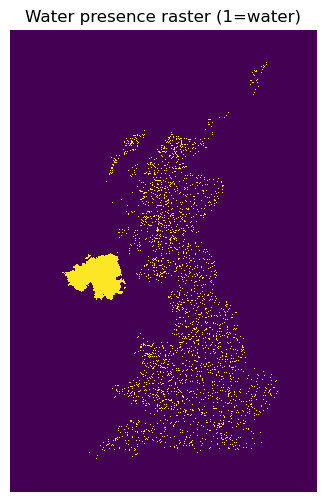

In [35]:
plt.figure(figsize=(6,6))
plt.imshow(water, interpolation="nearest")
plt.title("Water presence raster (1=water)")
plt.axis("off")
plt.show()


In [38]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", "GeoSeries.notna", UserWarning)

try:
    from scipy.ndimage import distance_transform_edt
except ImportError:
    raise ImportError("缺少 scipy：运行 conda install -c conda-forge scipy  或  pip install scipy")



BASE = "/Users/jsh/Desktop/assignment2 spatial"
os.makedirs(BASE, exist_ok=True)

dem_tif = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")
uk_boundary = os.path.join(BASE, "uk boundary.geojson")

gb_rivers_gpkg = os.path.join(BASE, "oprvrs_gb.gpkg")
gb_rivers_layer = "watercourse_link"

gb_lakes_gpkg  = os.path.join(BASE, "uklakes_v3_6poly_utf8.gpkg")
gb_lakes_layer = "uklakes_v3_6_poly_utf8"

ni_river_shp = os.path.join(BASE, "WFD_River_Water_Bodies_2016.shp")
ni_lake_shp  = os.path.join(BASE, "Lake_Water_Bodies_2016.shp")

DIST_M = 200

out_mask_tif = os.path.join(BASE, f"uk_water_constraints_{DIST_M}m_mask.tif")
out_png      = os.path.join(BASE, f"uk_water_constraints_{DIST_M}m_blue_boundary.png")



def clean_geom(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf[gdf.geometry.notna()].copy()
    gdf = gdf[~gdf.geometry.is_empty].copy()
    return gdf

def make_valid_safe(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = clean_geom(gdf)
    try:
        from shapely import make_valid
        gdf.loc[~gdf.is_valid, "geometry"] = gdf.loc[~gdf.is_valid, "geometry"].apply(make_valid)
    except Exception:
        gdf.loc[~gdf.is_valid, "geometry"] = gdf.loc[~gdf.is_valid, "geometry"].buffer(0)
    gdf = clean_geom(gdf)
    return gdf

def read_shp_encoding_robust(path: str) -> gpd.GeoDataFrame:
    for enc in ["cp1252", "latin1"]:
        try:
            return gpd.read_file(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    raise UnicodeDecodeError("utf-8", b"", 0, 1, f"Cannot decode DBF in {path}")

def bbox_filter(gdf: gpd.GeoDataFrame, bounds) -> gpd.GeoDataFrame:
    minx, miny, maxx, maxy = bounds
    return gdf.cx[minx:maxx, miny:maxy]

def filter_ni_river_polygons(ni_riv: gpd.GeoDataFrame) -> gpd.GeoDataFrame:

    ni_riv = make_valid_safe(ni_riv)

    area_m2 = ni_riv.geometry.area
    perim_m = ni_riv.geometry.length.replace(0, np.nan)

    width_m = (2 * area_m2 / perim_m).replace([np.inf, -np.inf], np.nan)

    ni_riv = ni_riv.assign(_area_km2=area_m2/1e6, _width_m=width_m)

    ni_riv = ni_riv[(ni_riv["_width_m"] < 1000) & (ni_riv["_area_km2"] < 50)].copy()

    print("NI river kept:", len(ni_riv))
    if len(ni_riv) > 0:
        print("NI river max area_km2 after filter:", ni_riv["_area_km2"].max())
        print("NI river max width_m after filter:", ni_riv["_width_m"].max())


    ni_riv = ni_riv.drop(columns=[c for c in ["_area_km2", "_width_m"] if c in ni_riv.columns], errors="ignore")
    return ni_riv



with rasterio.open(dem_tif) as src:
    dem_crs = src.crs
    transform = src.transform
    H, W = src.height, src.width
    nodata = src.nodata
    dem = src.read(1)
    dem_bounds = src.bounds  # left, bottom, right, top

valid_area = np.ones((H, W), dtype=bool) if nodata is None else (dem != nodata)

px_x = abs(transform.a)
px_y = abs(transform.e)

print("DEM CRS:", dem_crs)
print("DEM shape:", (H, W))
print("Pixel size (m):", px_x, px_y)



uk = gpd.read_file(uk_boundary)
uk = clean_geom(uk).to_crs(dem_crs)
uk = make_valid_safe(uk)

try:
    uk_outer = uk.dissolve()
    uk_outer = make_valid_safe(uk_outer)
except Exception:

    uk_outer = uk

uk_bounds = uk_outer.total_bounds 



gb_riv = gpd.read_file(gb_rivers_gpkg, layer=gb_rivers_layer)
gb_riv = clean_geom(gb_riv).to_crs(dem_crs)
gb_riv = bbox_filter(gb_riv, uk_bounds)
gb_riv = make_valid_safe(gb_riv)

gb_lakes = gpd.read_file(gb_lakes_gpkg, layer=gb_lakes_layer)
gb_lakes = clean_geom(gb_lakes).to_crs(dem_crs)
gb_lakes = bbox_filter(gb_lakes, uk_bounds)
gb_lakes = make_valid_safe(gb_lakes)

ni_riv = read_shp_encoding_robust(ni_river_shp)
ni_riv = clean_geom(ni_riv).to_crs(dem_crs)
ni_riv = bbox_filter(ni_riv, uk_bounds)
ni_riv = filter_ni_river_polygons(ni_riv)  

ni_lake = read_shp_encoding_robust(ni_lake_shp)
ni_lake = clean_geom(ni_lake).to_crs(dem_crs)
ni_lake = bbox_filter(ni_lake, uk_bounds)
ni_lake = make_valid_safe(ni_lake)




poly_geoms = list(gb_lakes.geometry) + list(ni_riv.geometry) + list(ni_lake.geometry)
poly_shapes = [(geom, 1) for geom in poly_geoms if geom is not None]

water_poly = features.rasterize(
    poly_shapes,
    out_shape=(H, W),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True
)


line_shapes = [(geom, 1) for geom in gb_riv.geometry if geom is not None]
water_riv = features.rasterize(
    line_shapes,
    out_shape=(H, W),
    transform=transform,
    fill=0,
    dtype="uint8",
    all_touched=True
)

water = np.maximum(water_poly, water_riv)



dist_m = distance_transform_edt((water == 0), sampling=(px_y, px_x))
unavailable = dist_m <= DIST_M



final = np.zeros((H, W), dtype=np.uint8)
final[unavailable] = 1
final[~valid_area] = 255

profile = {
    "driver": "GTiff",
    "height": H,
    "width": W,
    "count": 1,
    "dtype": "uint8",
    "crs": dem_crs,
    "transform": transform,
    "compress": "LZW",
    "nodata": 255
}

with rasterio.open(out_mask_tif, "w", **profile) as dst:
    dst.write(final, 1)

print("✅ Saved mask:", out_mask_tif)



viz = final.copy()
viz[viz == 255] = 0 

cmap = ListedColormap(["white", "blue"])  

# Make imshow align to real coordinates
extent = (dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top)

fig, ax = plt.subplots(figsize=(7, 9))
ax.imshow(viz, cmap=cmap, interpolation="nearest", extent=extent, origin="upper")

# UK boundary outline (black)
uk_outer.boundary.plot(ax=ax, color="black", linewidth=0.3)

ax.set_title(f"UK Water Constraint (<= {DIST_M}m = Unavailable)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.close(fig)

print("✅ Saved preview:", out_png)


DEM CRS: EPSG:3035
DEM shape: (13940, 9235)
Pixel size (m): 94.93064481538696 94.93064481538696
NI river kept: 80
NI river max area_km2 after filter: 26.157717804469993
NI river max width_m after filter: 998.9353945358748
✅ Saved mask: /Users/jsh/Desktop/assignment2 spatial/uk_water_constraints_200m_mask.tif
✅ Saved preview: /Users/jsh/Desktop/assignment2 spatial/uk_water_constraints_200m_blue_boundary.png


In [40]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

BASE = "/Users/jsh/Desktop/assignment2 spatial"

existing_final_mask_tif = os.path.join(BASE, "uk_hard_constraints_plus_protected_mask.tif")


water_mask_tif = os.path.join(BASE, "uk_water_constraints_200m_mask.tif")


dem_tif = os.path.join(BASE, "uk_dem_clipped_UK_epsg3035.tif")

boundary_geojson = os.path.join(BASE, "uk boundary.geojson")

out_final_mask_tif = os.path.join(BASE, "uk_final_mask_plus_water_200m.tif")
out_png = os.path.join(BASE, "uk_final_availability_plus_water_200m.png")


def read_align_to_ref(src_path, ref):

    with rasterio.open(src_path) as src:
        src_arr = src.read(1)

        same = (src.crs == ref["crs"] and
                src.transform == ref["transform"] and
                src.width == ref["width"] and
                src.height == ref["height"])
        if same:
            return src_arr.astype(np.uint8)

        dst = np.full((ref["height"], ref["width"]), 255, dtype=np.uint8)
        reproject(
            source=src_arr,
            destination=dst,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref["transform"],
            dst_crs=ref["crs"],
            resampling=Resampling.nearest
        )
        return dst


with rasterio.open(dem_tif) as demsrc:
    ref = {
        "crs": demsrc.crs,
        "transform": demsrc.transform,
        "width": demsrc.width,
        "height": demsrc.height
    }
    dem = demsrc.read(1)
    dem_nodata = demsrc.nodata
    dem_bounds = demsrc.bounds

valid_area = np.ones(dem.shape, dtype=bool) if dem_nodata is None else (dem != dem_nodata)


existing = read_align_to_ref(existing_final_mask_tif, ref)
water = read_align_to_ref(water_mask_tif, ref)


existing_unavail = (existing == 1) & valid_area
water_unavail = (water == 1) & valid_area

combined_unavail = existing_unavail | water_unavail


final = np.full(dem.shape, 255, dtype=np.uint8)   # 背景全是 nodata
final[valid_area] = 0
final[combined_unavail] = 1


added_by_water = np.sum(water_unavail & (~existing_unavail))
print("✅ Pixels newly excluded by water (within valid DEM area):", int(added_by_water))


profile = {
    "driver": "GTiff",
    "height": ref["height"],
    "width": ref["width"],
    "count": 1,
    "dtype": "uint8",
    "crs": ref["crs"],
    "transform": ref["transform"],
    "compress": "LZW",
    "nodata": 255
}

with rasterio.open(out_final_mask_tif, "w", **profile) as dst:
    dst.write(final, 1)

print("✅ Saved final mask:", out_final_mask_tif)


m = np.ma.masked_where(final == 255, final)

cmap = ListedColormap(["#2ca25f", "#de2d26"])  # 0=green, 1=red
cmap.set_bad(color="white")                    # nodata=white

extent = (dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top)

fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(m, cmap=cmap, interpolation="nearest", extent=extent, origin="upper")


uk = gpd.read_file(boundary_geojson).to_crs(ref["crs"])
uk = uk[uk.geometry.notna() & ~uk.geometry.is_empty].copy()
try:
    uk.dissolve().boundary.plot(ax=ax, color="black", linewidth=0.6)
except Exception:
    uk.boundary.plot(ax=ax, color="black", linewidth=0.4)

ax.set_title("UK Final Land Availability (Hard + Protected + Built-up/Airports + Water 200m)", fontsize=12)
ax.set_axis_off()

import matplotlib.patches as mpatches
legend_items = [
    mpatches.Patch(color="#2ca25f", label="Available (passes all constraints)"),
    mpatches.Patch(color="#de2d26", label="Unavailable (fails ≥1 constraint)"),
]
ax.legend(handles=legend_items, loc="lower left", frameon=True)

plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.close(fig)

print("✅ Saved PNG:", out_png)


✅ Pixels newly excluded by water (within valid DEM area): 5379059
✅ Saved final mask: /Users/jsh/Desktop/assignment2 spatial/uk_final_mask_plus_water_200m.tif
✅ Saved PNG: /Users/jsh/Desktop/assignment2 spatial/uk_final_availability_plus_water_200m.png


In [47]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

BASE = "/Users/jsh/Desktop/assignment2 spatial"


final_tif = os.path.join(BASE, "uk_suitability_score_ahp_masked.tif")
out_png   = os.path.join(BASE, "uk_suitability_score_ahp_masked_boundary.png")


boundary = os.path.join(BASE, "uk boundary.geojson") 
with rasterio.open(final_tif) as ds:
    arr = ds.read(1).astype(np.float32)
    nod = ds.nodata
    meta = ds.meta.copy()
    extent = (ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top)


if nod is not None:
    arr = np.where(arr == nod, np.nan, arr)


m = np.ma.masked_invalid(arr)
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="#1a1a1a")   、


plt.figure(figsize=(6, 8))
im = plt.imshow(m, cmap=cmap, vmin=0, vmax=1, extent=extent, origin="upper")
plt.title("UK suitability score (AHP) + hard constraints")
plt.axis("off")
cb = plt.colorbar(im, fraction=0.04, pad=0.02)
cb.set_label("Suitability score")

try:
    g = gpd.read_file(boundary)
    g = g.to_crs(meta["crs"])   
    g.boundary.plot(ax=plt.gca(), color="black", linewidth=0.6)
except Exception as e:
    print("[WARN] boundary overlay failed:", e)

plt.tight_layout()
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.close()

print("[OK] saved:", out_png)


[OK] saved: /Users/jsh/Desktop/assignment2 spatial/uk_suitability_score_ahp_masked_boundary.png


In [48]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import xy
from pyproj import Transformer
import json

BASE = "/Users/jsh/Desktop/assignment2 spatial"  


in_tif = os.path.join(BASE, "uk_suitability_score_ahp_masked.tif")

# 输出
out_csv    = os.path.join(BASE, "top20_spaced_points.csv")
out_geojs  = os.path.join(BASE, "top20_spaced_points.geojson")

TOP_N = 20


min_dist_km_candidates = [30, 25, 20, 15]   

def select_points_with_min_distance(arr, ds, top_n, min_dist_m):
    """Greedy selection: highest score first, keep points at least min_dist_m apart."""
    valid = np.isfinite(arr)
    if valid.sum() == 0:
        return []

    flat = np.where(valid, arr, -np.inf).ravel()
    idx_sorted = np.argsort(flat)[::-1]  

    selected = []
    for idx in idx_sorted:
        s = flat[idx]
        if not np.isfinite(s):
            break

        r, c = np.unravel_index(idx, arr.shape)
        x, y = xy(ds.transform, r, c, offset="center")

        
        ok = True
        for (_, _, _, xs, ys) in selected:
            if (x - xs) ** 2 + (y - ys) ** 2 < (min_dist_m ** 2):
                ok = False
                break
        if not ok:
            continue

        selected.append((r, c, float(s), float(x), float(y)))
        if len(selected) == top_n:
            break

    return selected

with rasterio.open(in_tif) as ds:
    arr = ds.read(1).astype(np.float32)
    nod = ds.nodata
    crs = ds.crs

if nod is not None:
    arr = np.where(arr == nod, np.nan, arr)


selected = []
used_km = None

with rasterio.open(in_tif) as ds:
    for km in min_dist_km_candidates:
        sel = select_points_with_min_distance(arr, ds, TOP_N, km * 1000.0)
        if len(sel) >= TOP_N:
            selected = sel
            used_km = km
            break

if used_km is None:
    used_km = min_dist_km_candidates[-1]
    with rasterio.open(in_tif) as ds:
        selected = select_points_with_min_distance(arr, ds, TOP_N, used_km * 1000.0)

print(f"[OK] selected {len(selected)} points with MIN_DIST_KM={used_km} km")


to_wgs84 = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

records = []
for rank, (r, c, s, x, y) in enumerate(selected, start=1):
    lon, lat = to_wgs84.transform(x, y)
    records.append({
        "rank": rank,
        "score": s,
        "x_epsg27700": x,
        "y_epsg27700": y,
        "lon": lon,
        "lat": lat,
        "min_dist_km_used": used_km
    })

df = pd.DataFrame(records)
df.to_csv(out_csv, index=False)
print("[OK] saved CSV:", out_csv)


geojson = {"type": "FeatureCollection", "features": []}
for rec in records:
    geojson["features"].append({
        "type": "Feature",
        "geometry": {"type": "Point", "coordinates": [rec["x_epsg27700"], rec["y_epsg27700"]]},
        "properties": {"rank": rec["rank"], "score": rec["score"], "min_km": rec["min_dist_km_used"]}
    })

with open(out_geojs, "w", encoding="utf-8") as f:
    json.dump(geojson, f, ensure_ascii=False)

print("[OK] saved GeoJSON:", out_geojs)
print(df[["rank", "score", "x_epsg27700", "y_epsg27700", "min_dist_km_used"]])


[OK] selected 20 points with MIN_DIST_KM=30 km
[OK] saved CSV: /Users/jsh/Desktop/assignment2 spatial/top20_spaced_points.csv
[OK] saved GeoJSON: /Users/jsh/Desktop/assignment2 spatial/top20_spaced_points.geojson
    rank     score  x_epsg27700  y_epsg27700  min_dist_km_used
0      1  0.992500     412500.0     397500.0                30
1      2  0.992500     362500.0     662500.0                30
2      3  0.965352     262500.0     772500.0                30
3      4  0.939896     237500.0     927500.0                30
4      5  0.922208     272500.0     372500.0                30
5      6  0.903302     232500.0     392500.0                30
6      7  0.900000     442500.0    1132500.0                30
7      8  0.898938     397500.0     622500.0                30
8      9  0.896010     127500.0     857500.0                30
9     10  0.889903     227500.0     722500.0                30
10    11  0.889788     327500.0     232500.0                30
11    12  0.881500     397500.0